In [2]:
import pandas as pd
pd.set_option('display.max_colwidth', None)

df_train = pd.read_csv('train_spam.csv', index_col=None)

df_train.groupby('text_type').count()

,text
text_type,
ham,11469
spam,4809


In [4]:
import re
import emoji
import unicodedata
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import fasttext

from statistics import mean

class SpamFilter:
    def __init__(self):
        self.estimators = []
        self.stop_words = set(stopwords.words('english'))

    def text_preprocessing(self, raw_text):
        # 1. deleting unnecessary information
        # 1.1. HTML-tags
        pure_text = re.sub(r'<[^<]+?>', '', raw_text)
        # 1.2. links
        pure_text = re.sub(r'http\S+', '', pure_text)
        # 1.3. social media tags
        pure_text = re.sub(r'@\S+', '', pure_text)
        
        # 2. replacing special characters
        # 2.1. converting emoji to text description
        pure_text = emoji.demojize(pure_text, delimiters=(" ", " ")).replace("_", " ")
        # 2.2. replacing diacritics with ASCII characters and converting to 'UTF-8'
        pure_text = unicodedata.normalize('NFKD', pure_text)
        pure_text.encode('ascii', 'ignore').decode('utf-8', 'ignore')
        
        # 3. deleting non-(letters/whitespaces)
        pure_text = re.sub(r"[^a-zA-Z'\s]", '', pure_text)
        
        # 4. replacing sequens of whitespaces
        pure_text = re.sub('\s+', ' ', pure_text)
        
        # 5. converting to lowercase
        pure_text = pure_text.lower()
        
        # 6. removing stop-wodrs
        tokens = word_tokenize(pure_text)
        tokens = [token for token in tokens if token not in self.stop_words]
        clean_text = ' '.join(tokens)

        return pure_text

    def fit(self, messages, labels):
        with open('train.txt', 'w') as f:
            for lbl, mssg in zip(labels, messages):
                f.writelines(f"__label__{lbl} {self.text_preprocessing(mssg)}\n")
        self.estimators.append(fasttext.train_supervised('train.txt'))
        # ensambling does not affect on roc_auc_score
        #self.estimators.append(fasttext.train_supervised('train.txt', wordNgrams=2, epoch=10))
        #self.estimators.append(fasttext.train_supervised('train.txt', wordNgrams=3, epoch=15))
    
    def predict(self, messages):
        # returns labels 'spam' or 'ham'
        predictions = []
        probabilities = self.predict_proba(messages)
        for prob in probabilities:
            pred = 'spam' if prob >= 0.5 else 'ham'
            predictions.append(pred)
        return predictions
    
    @staticmethod
    def output_processor(pred):
        # fasttext.predict() output: ( ("most probable label",), array(["it's probability"]) )
        lbl = pred[0][0]
        prob = pred[1][0]
        # sometimes fasttext.predict() returns a probability slightly more than unity
        prob = prob if prob <= 1.0 else 1.0
        # returns the probability of being spam
        return prob if lbl == '__label__spam' else 1 - prob

    def predict_proba(self, messages):
        # returns the probabilities of being spam
        probabilities = []
        for mssg in messages:
            probs = []
            for est in self.estimators:
                probs.append( self.output_processor( est.predict(self.text_preprocessing(mssg)) ) )
            probabilities.append(mean(probs))
        return probabilities

In [6]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df_train, test_size = 0.2, random_state=42)

SF = SpamFilter()
SF.fit(train['text'], train['text_type'])

Read 0M words
Number of words:  37610
Number of labels: 2
Progress: 100.0% words/sec/thread: 2557737 lr:  0.000000 avg.loss:  0.156640 ETA:   0h 0m 0s


precision=0.9376391982182628
recall=0.9005347593582887
f1=0.9187124931805782
roc_auc=0.9841141219325065


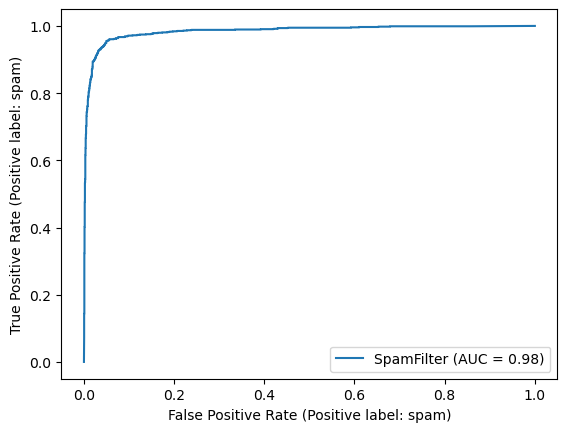

In [8]:
from sklearn.metrics import precision_score, recall_score, f1_score, RocCurveDisplay, roc_auc_score

predictions = SF.predict(test['text'])
probabilities = SF.predict_proba(test['text'])

RocCurveDisplay.from_predictions(test['text_type'], probabilities, pos_label='spam', name='SpamFilter')


precision = precision_score(test['text_type'], predictions, labels=['ham', 'spam'], pos_label='spam')
recall = recall_score(test['text_type'], predictions, labels=['ham', 'spam'], pos_label='spam')
f1 = f1_score(test['text_type'], predictions, labels=['ham', 'spam'], pos_label='spam')
roc_auc = roc_auc_score(test['text_type'], probabilities)

print(f'{precision=}\n{recall=}\n{f1=}\n{roc_auc=}')

In [10]:
from sklearn.model_selection import KFold

for i in range(5):
    kf = KFold(n_splits=5, shuffle=True)
    results = []
    for train_index, test_index in kf.split(df_train):
        train = df_train.iloc[train_index]
        test = df_train.iloc[test_index]
        
        SF = SpamFilter()
        SF.fit(train['text'], train['text_type'])
        
        predictions = SF.predict(test['text'])
        probabilities = SF.predict_proba(test['text'])
        
        pr = precision_score(test['text_type'], predictions, labels=['ham', 'spam'], pos_label='spam')
        rc = recall_score(test['text_type'], predictions, labels=['ham', 'spam'], pos_label='spam')
        f1 = f1_score(test['text_type'], predictions, labels=['ham', 'spam'], pos_label='spam')
        roc = roc_auc_score(test['text_type'], probabilities)
        
        results.append([pr, rc, f1, roc])
        
    results = pd.DataFrame(results, columns=['precision', 'recall', 'f1', 'roc_auc'])
    display(results)
    print(results.mean())

Read 0M words
Number of words:  37474
Number of labels: 2
Progress: 100.0% words/sec/thread: 2604969 lr:  0.000000 avg.loss:  0.161909 ETA:   0h 0m 0s
Read 0M words
Number of words:  37677
Number of labels: 2
Progress: 100.0% words/sec/thread: 2558765 lr:  0.000000 avg.loss:  0.175010 ETA:   0h 0m 0s
Read 0M words
Number of words:  37557
Number of labels: 2
Progress: 100.0% words/sec/thread: 2608269 lr:  0.000000 avg.loss:  0.165379 ETA:   0h 0m 0s
Read 0M words
Number of words:  37866
Number of labels: 2
Progress: 100.0% words/sec/thread: 2560892 lr:  0.000000 avg.loss:  0.176489 ETA:   0h 0m 0s
Read 0M words
Number of words:  37706
Number of labels: 2
Progress: 100.0% words/sec/thread: 2599073 lr:  0.000000 avg.loss:  0.165594 ETA:   0h 0m 0s


,precision,recall,f1,roc_auc
0,0.937568,0.887967,0.912094,0.973175
1,0.949267,0.896699,0.922234,0.983585
2,0.939262,0.899273,0.918833,0.980546
3,0.951974,0.893788,0.921964,0.982774
4,0.940639,0.871958,0.904997,0.982610


precision    0.943742
recall       0.889937
f1           0.916024
roc_auc      0.980538
dtype: float64


Read 0M words
Number of words:  37720
Number of labels: 2
Progress: 100.0% words/sec/thread: 2565021 lr:  0.000000 avg.loss:  0.167532 ETA:   0h 0m 0s
Read 0M words
Number of words:  37577
Number of labels: 2
Progress: 100.0% words/sec/thread: 2542930 lr:  0.000000 avg.loss:  0.165250 ETA:   0h 0m 0s
Read 0M words
Number of words:  38009
Number of labels: 2
Progress: 100.0% words/sec/thread: 2579405 lr:  0.000000 avg.loss:  0.167280 ETA:   0h 0m 0s
Read 0M words
Number of words:  37595
Number of labels: 2
Progress: 100.0% words/sec/thread: 2604577 lr:  0.000000 avg.loss:  0.165911 ETA:   0h 0m 0s
Read 0M words
Number of words:  37588
Number of labels: 2
Progress: 100.0% words/sec/thread: 2634559 lr:  0.000000 avg.loss:  0.168161 ETA:   0h 0m 0s


,precision,recall,f1,roc_auc
0,0.941176,0.901408,0.920863,0.979061
1,0.945455,0.888889,0.916300,0.979619
2,0.941309,0.895811,0.917997,0.984203
3,0.937367,0.887437,0.911719,0.979487
4,0.957399,0.896118,0.925745,0.982253


precision    0.944541
recall       0.893933
f1           0.918525
roc_auc      0.980925
dtype: float64


Read 0M words
Number of words:  37974
Number of labels: 2
Progress: 100.0% words/sec/thread: 2584849 lr:  0.000000 avg.loss:  0.170823 ETA:   0h 0m 0s
Read 0M words
Number of words:  37553
Number of labels: 2
Progress: 100.0% words/sec/thread: 2565006 lr:  0.000000 avg.loss:  0.168070 ETA:   0h 0m 0s
Read 0M words
Number of words:  37629
Number of labels: 2
Progress: 100.0% words/sec/thread: 2546500 lr:  0.000000 avg.loss:  0.166043 ETA:   0h 0m 0s
Read 0M words
Number of words:  37623
Number of labels: 2
Progress: 100.0% words/sec/thread: 2623055 lr:  0.000000 avg.loss:  0.159707 ETA:   0h 0m 0s
Read 0M words
Number of words:  37608
Number of labels: 2
Progress: 100.0% words/sec/thread: 2547392 lr:  0.000000 avg.loss:  0.173895 ETA:   0h 0m 0s


,precision,recall,f1,roc_auc
0,0.941685,0.891616,0.915966,0.979493
1,0.945279,0.893509,0.918665,0.985427
2,0.950562,0.891465,0.920065,0.979646
3,0.930832,0.863983,0.896163,0.976676
4,0.932059,0.898669,0.915060,0.981463


precision    0.940083
recall       0.887848
f1           0.913184
roc_auc      0.980541
dtype: float64


Read 0M words
Number of words:  37664
Number of labels: 2
Progress: 100.0% words/sec/thread: 2528514 lr:  0.000000 avg.loss:  0.168005 ETA:   0h 0m 0s
Read 0M words
Number of words:  37519
Number of labels: 2
Progress: 100.0% words/sec/thread: 2576350 lr:  0.000000 avg.loss:  0.164956 ETA:   0h 0m 0s
Read 0M words
Number of words:  37792
Number of labels: 2
Progress: 100.0% words/sec/thread: 2521876 lr:  0.000000 avg.loss:  0.172536 ETA:   0h 0m 0s
Read 0M words
Number of words:  37704
Number of labels: 2
Progress: 100.0% words/sec/thread: 2516342 lr:  0.000000 avg.loss:  0.170851 ETA:   0h 0m 0s
Read 0M words
Number of words:  37706
Number of labels: 2
Progress: 100.0% words/sec/thread: 2571045 lr:  0.000000 avg.loss:  0.164754 ETA:   0h 0m 0s


,precision,recall,f1,roc_auc
0,0.948913,0.878270,0.912226,0.982711
1,0.946903,0.884298,0.914530,0.981930
2,0.928649,0.918717,0.923656,0.983707
3,0.926616,0.900000,0.913114,0.978007
4,0.958998,0.866255,0.910270,0.975518


precision    0.942016
recall       0.889508
f1           0.914759
roc_auc      0.980375
dtype: float64


Read 0M words
Number of words:  37589
Number of labels: 2
Progress: 100.0% words/sec/thread: 2610908 lr:  0.000000 avg.loss:  0.167170 ETA:   0h 0m 0s
Read 0M words
Number of words:  37909
Number of labels: 2
Progress: 100.0% words/sec/thread: 1722994 lr:  0.000000 avg.loss:  0.168676 ETA:   0h 0m 0s
Read 0M words
Number of words:  37716
Number of labels: 2
Progress: 100.0% words/sec/thread: 2639353 lr:  0.000000 avg.loss:  0.168727 ETA:   0h 0m 0s
Read 0M words
Number of words:  37569
Number of labels: 2
Progress: 100.0% words/sec/thread: 2590803 lr:  0.000000 avg.loss:  0.159825 ETA:   0h 0m 0s
Read 0M words
Number of words:  37654
Number of labels: 2
Progress: 100.0% words/sec/thread: 2556574 lr:  0.000000 avg.loss:  0.174020 ETA:   0h 0m 0s


,precision,recall,f1,roc_auc
0,0.948443,0.880359,0.913133,0.979878
1,0.952275,0.895616,0.923077,0.983687
2,0.947141,0.903292,0.924697,0.985192
3,0.936047,0.877863,0.906021,0.976594
4,0.928495,0.907195,0.917722,0.978137


precision    0.942480
recall       0.892865
f1           0.916930
roc_auc      0.980698
dtype: float64


In [12]:
df_test = pd.read_csv('test_spam.csv', index_col=None)

df_test.shape[0]

4070

In [14]:
spam_filter = SpamFilter()
spam_filter.fit(df_train['text'], df_train['text_type'])

Read 0M words
Number of words:  42541
Number of labels: 2
Progress: 100.0% words/sec/thread: 3292148 lr:  0.000000 avg.loss:  0.149559 ETA:   0h 0m 0s


In [16]:
probabilities = spam_filter.predict_proba(df_test['text'])
predictions = spam_filter.predict(df_test['text'])

In [18]:
import csv
 
with open('results_label.csv', 'w') as f:
    csvwriter = csv.writer(f)
    csvwriter.writerow(['score', 'text'])
    for pred, text in zip(predictions, df_test['text']):
        csvwriter.writerow([pred, text])
        
with open('results_proba.csv', 'w') as f:
    csvwriter = csv.writer(f)
    csvwriter.writerow(['score', 'text'])
    for prob, text in zip(probabilities, df_test['text']):
        csvwriter.writerow([prob, text])